In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly_express as px
import plotly.graph_objects as go
import warnings
from downcast import reduce
from plotly.subplots import make_subplots
from plotly.io import to_image
from IPython.display import Image
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from itertools import cycle
from kneed import KneeLocator
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


warnings.filterwarnings('ignore')
%matplotlib inline

In [258]:
prices = pd.read_pickle('../data/processed/item_prices.pkl')
sales = pd.read_pickle('../data/processed/item_sales.pkl')
calendar = pd.read_pickle('../data/processed/daily_calendar_with_events.pkl')

In [259]:
dcols = [c for c in sales.columns if 'd_' in c]

calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day

calendar_1 = calendar[['date', 'weekday', 'weekday_int', 'month', 'year']]

### Clustering por Item e Sales

In [260]:
itens = sales['item'].unique()
itens

['ACCESORIES_1_001', 'ACCESORIES_1_002', 'ACCESORIES_1_003', 'ACCESORIES_1_004', 'ACCESORIES_1_005', ..., 'SUPERMARKET_3_823', 'SUPERMARKET_3_824', 'SUPERMARKET_3_825', 'SUPERMARKET_3_826', 'SUPERMARKET_3_827']
Length: 3049
Categories (3049, object): ['ACCESORIES_1_001', 'ACCESORIES_1_002', 'ACCESORIES_1_003', 'ACCESORIES_1_004', ..., 'SUPERMARKET_3_824', 'SUPERMARKET_3_825', 'SUPERMARKET_3_826', 'SUPERMARKET_3_827']

In [261]:
sales.head(100)

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ACCESORIES_1_099_NYC_1,ACCESORIES_1_099,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2,1,1,...,0,1,0,1,2,0,0,0,0,2
96,ACCESORIES_1_100_NYC_1,ACCESORIES_1_100,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,2,2,...,2,3,1,3,0,0,1,1,1,1
97,ACCESORIES_1_102_NYC_1,ACCESORIES_1_102,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,0,1,0,1,0
98,ACCESORIES_1_103_NYC_1,ACCESORIES_1_103,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,25,8,5,...,7,8,4,0,10,2,4,0,2,5


In [262]:
sales_melted = sales.melt(id_vars=['id', 'item', 'category', 'department', 'store_code', 'region'], value_vars=[i for i in sales if i.startswith('d_')], var_name=['d'], value_name='sales')

In [263]:
merged = pd.merge(sales_melted, calendar, on='d', how='left')

In [264]:
df = merged.groupby([pd.Grouper(key='date', freq='M'),'id'])['sales'].sum().reset_index(name='sales')

In [265]:
pivot_df = df.pivot(index='id', columns='date', values='sales')
sales_matrix = pivot_df.values
#trocando de todos os 0 por 0.0001 para evitar divisão por 0
max_values = np.max(sales_matrix, axis=1)[:,None]
max_values = np.array(max_values, dtype='float64')
max_values[np.argmin(max_values)][0] = 0.0001

In [266]:
#normalização pelo maior numero de vendas por produto
normalized_sales_matrix = np.divide(sales_matrix, max_values)
pivot_df[pivot_df.columns] = normalized_sales_matrix
pivot_df.head()

date,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,...,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.350000,0.200000,0.400000,0.400000,0.300000,0.350000,0.300000,0.300000,0.600000,0.400000
ACCESORIES_1_001_BOS_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.409091,0.454545,0.909091,0.772727,0.909091,0.863636,1.000000,0.636364,0.409091,0.318182
ACCESORIES_1_001_BOS_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.666667,0.750000,0.625000,1.000000,0.833333,0.708333,0.666667,0.541667,0.333333
ACCESORIES_1_001_NYC_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.655172,0.862069,0.689655,0.620690,0.586207,0.758621,0.827586,1.000000,1.000000,0.896552
ACCESORIES_1_001_NYC_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.714286,0.642857,0.892857,0.571429,0.821429,0.642857,0.642857,0.642857,1.000000,0.607143


In [267]:
di = dict()
for column in pivot_df.columns:
    di[column] = pivot_df[pivot_df[column] == 0].shape[0]
cols = sorted(di, key=di.get, reverse=True)

In [298]:
nclusters = 10
def cluster(matrix, n_clusters=8):
    kmeans = KMeans(n_clusters)
    labels_kmeans = kmeans.fit_predict(matrix)
    print(labels_kmeans)
    cluster_df = pd.DataFrame()
    cluster_df['id'] = pivot_df.index
    cluster_df['cluster_kmeans'] = labels_kmeans
    return cluster_df

cluster_df = cluster(pivot_df[cols].values)
pivot_df['cluster_means'] = cluster_df['cluster_kmeans'].values
pivot_df.head()

[5 5 5 ... 5 7 5]


date,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,...,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,cluster_means
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.400000,0.400000,0.300000,0.350000,0.300000,0.300000,0.600000,0.400000,5
ACCESORIES_1_001_BOS_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.454545,0.909091,0.772727,0.909091,0.863636,1.000000,0.636364,0.409091,0.318182,5
ACCESORIES_1_001_BOS_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.750000,0.625000,1.000000,0.833333,0.708333,0.666667,0.541667,0.333333,5
ACCESORIES_1_001_NYC_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.862069,0.689655,0.620690,0.586207,0.758621,0.827586,1.000000,1.000000,0.896552,5
ACCESORIES_1_001_NYC_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.642857,0.892857,0.571429,0.821429,0.642857,0.642857,0.642857,1.000000,0.607143,5


In [269]:
len(df['date'].unique())

64

(4176, 65)
(4341, 65)
(5197, 65)
(3876, 65)


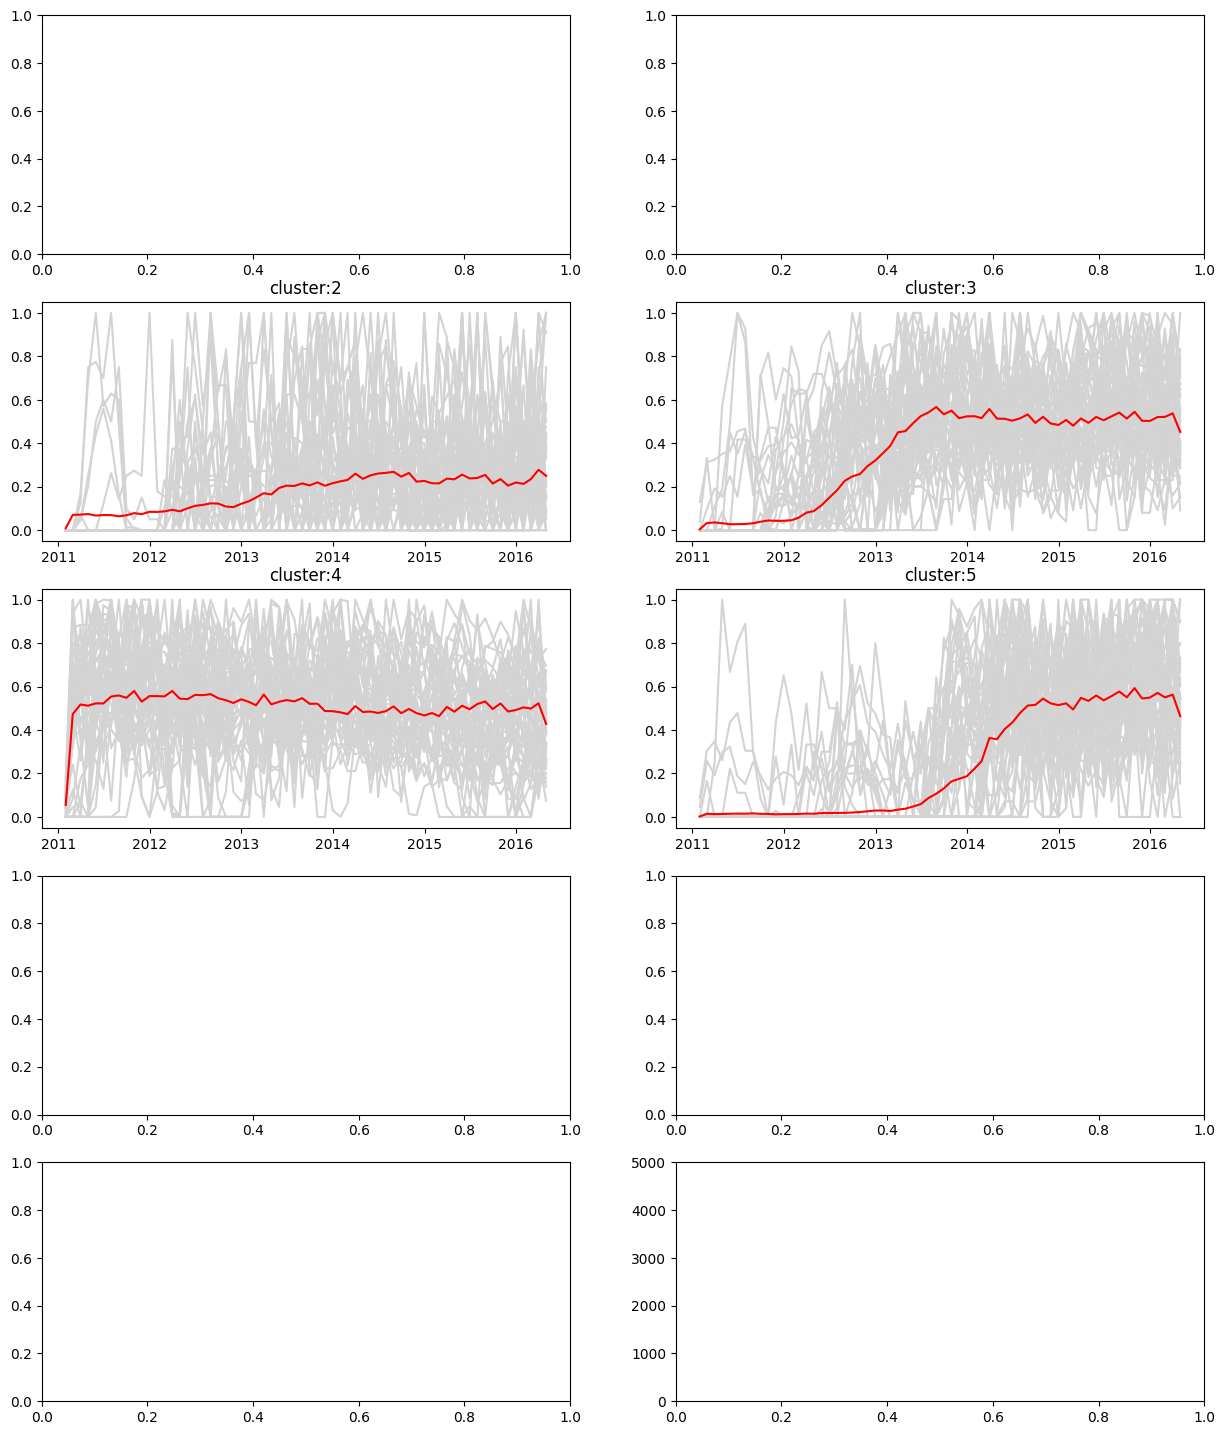

In [304]:
fig, ax = plt.subplots(nrows=int(nclusters/2), ncols=2, figsize=(15,18))

x, y = 0, 0
for j in range(2, 6):
    if j == 0:
        x = 0
        y = 0
    elif j % 2 == 0:
        x += 1 
        y = 0
    else:
        y += 1
    a = pivot_df[pivot_df['cluster_means'] == j]
    print(a.shape)
    for i in range(0, 50):
        ax[x, y].plot(df['date'].unique(), a.iloc[i, :-1].values, color='lightgrey');
    ax[x, y].plot(df['date'].unique(), a.iloc[:, :-1].values.mean(axis=0), color='red')
    ax[x, y].set_title('cluster:' + str(j))

plt.ylim(0, 5000)
plt.show()

> Não conseguimos resolver um problema com os clusters 1 e 7 por isso o plot está faltando

> Para checar os itens por cada grupo pode ser usado esse comando abaixo (trocar 0 pelo numero do cluster que quer ver)

In [309]:
pivot_df[pivot_df['cluster_means'] == 0]

date,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,...,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,cluster_means
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_PHI_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.176471,0.823529,0.764706,1.000000,0.764706,0.588235,0.823529,1.000000,0.470588,7
ACCESORIES_1_003_BOS_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.636364,0.818182,0.545455,1.000000,0.636364,0.272727,0.272727,0.636364,0.545455,7
ACCESORIES_1_003_NYC_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.266667,0.444444,0.355556,0.511111,1.000000,0.133333,0.200000,0.333333,0.355556,7
ACCESORIES_1_003_NYC_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.000000,0.277778,0.333333,1.000000,0.888889,1.000000,0.500000,0.833333,7
ACCESORIES_1_003_NYC_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.391304,0.304348,0.478261,0.478261,1.000000,0.260870,0.434783,0.608696,0.260870,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_827_BOS_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179104,0.373134,0.656716,0.507463,0.805970,0.835821,0.507463,0.611940,0.223881,7
SUPERMARKET_3_827_NYC_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.809524,0.761905,0.884354,0.938776,0.789116,0.619048,0.625850,0.870748,1.000000,7
SUPERMARKET_3_827_NYC_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.451923,0.480769,0.634615,0.990385,0.673077,0.836538,0.884615,1.000000,0.903846,7


### Clustering por Store e Department


In [55]:
stores = sales['store_code'].unique()
stores

['NYC_1', 'NYC_2', 'NYC_3', 'NYC_4', 'BOS_1', 'BOS_2', 'BOS_3', 'PHI_1', 'PHI_2', 'PHI_3']
Categories (10, object): ['BOS_1', 'BOS_2', 'BOS_3', 'NYC_1', ..., 'NYC_4', 'PHI_1', 'PHI_2', 'PHI_3']

In [56]:
departments = sales['department'].unique()
departments

['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1', 'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2', 'SUPERMARKET_3']
Categories (7, object): ['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1', 'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2', 'SUPERMARKET_3']

In [58]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1913 non-null   datetime64[ns]
 1   weekday      1913 non-null   category      
 2   weekday_int  1913 non-null   int8          
 3   d            1913 non-null   category      
 4   event        26 non-null     category      
dtypes: category(3), datetime64[ns](1), int8(1)
memory usage: 39.5 KB


In [61]:
past_sales = sales.set_index('id')[dcols].T.merge(calendar.set_index('d')['date'], left_index = True, right_index = True, validate = '1:1').set_index('date')
past_sales1 = past_sales.merge(calendar_1.set_index('date'), left_index = True, right_index = True, validate = '1:1')

In [63]:
a = []
concat = []
for store in stores:
    for dept in departments:
        concat.append(store+'_'+dept)
        cols = [c for c in past_sales1 if store in c and dept in c]
        a.append(past_sales1[cols].sum(axis=1).values)

In [64]:
final = {}
for i in range(0, len(a)):
    final[concat[i]] = a[i]

In [65]:
final.keys()

dict_keys(['NYC_1_ACCESORIES_1', 'NYC_1_ACCESORIES_2', 'NYC_1_HOME_&_GARDEN_1', 'NYC_1_HOME_&_GARDEN_2', 'NYC_1_SUPERMARKET_1', 'NYC_1_SUPERMARKET_2', 'NYC_1_SUPERMARKET_3', 'NYC_2_ACCESORIES_1', 'NYC_2_ACCESORIES_2', 'NYC_2_HOME_&_GARDEN_1', 'NYC_2_HOME_&_GARDEN_2', 'NYC_2_SUPERMARKET_1', 'NYC_2_SUPERMARKET_2', 'NYC_2_SUPERMARKET_3', 'NYC_3_ACCESORIES_1', 'NYC_3_ACCESORIES_2', 'NYC_3_HOME_&_GARDEN_1', 'NYC_3_HOME_&_GARDEN_2', 'NYC_3_SUPERMARKET_1', 'NYC_3_SUPERMARKET_2', 'NYC_3_SUPERMARKET_3', 'NYC_4_ACCESORIES_1', 'NYC_4_ACCESORIES_2', 'NYC_4_HOME_&_GARDEN_1', 'NYC_4_HOME_&_GARDEN_2', 'NYC_4_SUPERMARKET_1', 'NYC_4_SUPERMARKET_2', 'NYC_4_SUPERMARKET_3', 'BOS_1_ACCESORIES_1', 'BOS_1_ACCESORIES_2', 'BOS_1_HOME_&_GARDEN_1', 'BOS_1_HOME_&_GARDEN_2', 'BOS_1_SUPERMARKET_1', 'BOS_1_SUPERMARKET_2', 'BOS_1_SUPERMARKET_3', 'BOS_2_ACCESORIES_1', 'BOS_2_ACCESORIES_2', 'BOS_2_HOME_&_GARDEN_1', 'BOS_2_HOME_&_GARDEN_2', 'BOS_2_SUPERMARKET_1', 'BOS_2_SUPERMARKET_2', 'BOS_2_SUPERMARKET_3', 'BOS_3_ACCE

In [66]:
store_dept = pd.DataFrame(final)
store_dept.head()

,NYC_1_ACCESORIES_1,NYC_1_ACCESORIES_2,NYC_1_HOME_&_GARDEN_1,NYC_1_HOME_&_GARDEN_2,NYC_1_SUPERMARKET_1,NYC_1_SUPERMARKET_2,NYC_1_SUPERMARKET_3,NYC_2_ACCESORIES_1,NYC_2_ACCESORIES_2,NYC_2_HOME_&_GARDEN_1,...,PHI_2_SUPERMARKET_1,PHI_2_SUPERMARKET_2,PHI_2_SUPERMARKET_3,PHI_3_ACCESORIES_1,PHI_3_ACCESORIES_2,PHI_3_HOME_&_GARDEN_1,PHI_3_HOME_&_GARDEN_2,PHI_3_SUPERMARKET_1,PHI_3_SUPERMARKET_2,PHI_3_SUPERMARKET_3
0,528,28,361,181,297,674,2268,522,16,529,...,191,155,1269,256,22,584,148,152,583,2293
1,489,9,350,170,284,655,2198,381,16,461,...,184,128,1121,342,14,541,195,138,585,2383
2,409,6,279,114,214,396,1398,352,16,306,...,154,199,1233,228,20,420,106,127,575,1841
3,383,9,278,123,175,476,1607,344,6,270,...,205,244,1564,183,11,327,94,98,533,1965
4,263,5,195,135,182,354,1496,283,13,217,...,96,147,724,70,4,151,53,87,340,1427


In [67]:
store_dept['date'] = calendar['date']
store_dept['month'] = calendar['month']

In [68]:
store_dept.head()

,NYC_1_ACCESORIES_1,NYC_1_ACCESORIES_2,NYC_1_HOME_&_GARDEN_1,NYC_1_HOME_&_GARDEN_2,NYC_1_SUPERMARKET_1,NYC_1_SUPERMARKET_2,NYC_1_SUPERMARKET_3,NYC_2_ACCESORIES_1,NYC_2_ACCESORIES_2,NYC_2_HOME_&_GARDEN_1,...,PHI_2_SUPERMARKET_3,PHI_3_ACCESORIES_1,PHI_3_ACCESORIES_2,PHI_3_HOME_&_GARDEN_1,PHI_3_HOME_&_GARDEN_2,PHI_3_SUPERMARKET_1,PHI_3_SUPERMARKET_2,PHI_3_SUPERMARKET_3,date,month
0,528,28,361,181,297,674,2268,522,16,529,...,1269,256,22,584,148,152,583,2293,2011-01-29,1
1,489,9,350,170,284,655,2198,381,16,461,...,1121,342,14,541,195,138,585,2383,2011-01-30,1
2,409,6,279,114,214,396,1398,352,16,306,...,1233,228,20,420,106,127,575,1841,2011-01-31,1
3,383,9,278,123,175,476,1607,344,6,270,...,1564,183,11,327,94,98,533,1965,2011-02-01,2
4,263,5,195,135,182,354,1496,283,13,217,...,724,70,4,151,53,87,340,1427,2011-02-02,2


In [69]:
store_dept['date'] = pd.to_datetime(store_dept['date'])

### Monthly Level

In [70]:
month_level = pd.DataFrame()

In [71]:
store_dept.head()

,NYC_1_ACCESORIES_1,NYC_1_ACCESORIES_2,NYC_1_HOME_&_GARDEN_1,NYC_1_HOME_&_GARDEN_2,NYC_1_SUPERMARKET_1,NYC_1_SUPERMARKET_2,NYC_1_SUPERMARKET_3,NYC_2_ACCESORIES_1,NYC_2_ACCESORIES_2,NYC_2_HOME_&_GARDEN_1,...,PHI_2_SUPERMARKET_3,PHI_3_ACCESORIES_1,PHI_3_ACCESORIES_2,PHI_3_HOME_&_GARDEN_1,PHI_3_HOME_&_GARDEN_2,PHI_3_SUPERMARKET_1,PHI_3_SUPERMARKET_2,PHI_3_SUPERMARKET_3,date,month
0,528,28,361,181,297,674,2268,522,16,529,...,1269,256,22,584,148,152,583,2293,2011-01-29,1
1,489,9,350,170,284,655,2198,381,16,461,...,1121,342,14,541,195,138,585,2383,2011-01-30,1
2,409,6,279,114,214,396,1398,352,16,306,...,1233,228,20,420,106,127,575,1841,2011-01-31,1
3,383,9,278,123,175,476,1607,344,6,270,...,1564,183,11,327,94,98,533,1965,2011-02-01,2
4,263,5,195,135,182,354,1496,283,13,217,...,724,70,4,151,53,87,340,1427,2011-02-02,2


In [72]:
def store_cat_month(month_level):
    for col in store_dept.drop(['date', 'month'], axis = 1).columns:
        month_level[col] = store_dept.resample('M', on='date')[col].sum().values
    return month_level

In [73]:
month_level = store_cat_month(month_level)

In [74]:
month_level = month_level.reset_index()

In [75]:
month_level

,index,NYC_1_ACCESORIES_1,NYC_1_ACCESORIES_2,NYC_1_HOME_&_GARDEN_1,NYC_1_HOME_&_GARDEN_2,NYC_1_SUPERMARKET_1,NYC_1_SUPERMARKET_2,NYC_1_SUPERMARKET_3,NYC_2_ACCESORIES_1,NYC_2_ACCESORIES_2,...,PHI_2_SUPERMARKET_1,PHI_2_SUPERMARKET_2,PHI_2_SUPERMARKET_3,PHI_3_ACCESORIES_1,PHI_3_ACCESORIES_2,PHI_3_HOME_&_GARDEN_1,PHI_3_HOME_&_GARDEN_2,PHI_3_SUPERMARKET_1,PHI_3_SUPERMARKET_2,PHI_3_SUPERMARKET_3
0,0,1426,43,990,465,795,1725,5864,1255,48,...,529,482,3623,826,56,1545,449,417,1743,6517
1,1,11855,357,8213,3886,6595,12962,45566,9499,499,...,4810,5727,28016,6679,379,11494,3380,3863,16451,55713
2,2,12066,616,9076,4413,6952,13050,47295,10898,631,...,4868,5861,25897,7265,622,13448,3224,4036,15525,53747
3,3,12655,625,10035,4623,5507,12589,45519,10490,630,...,4040,5178,24396,7621,645,12363,3154,4326,14716,48654
4,4,12261,696,9316,4631,5569,13250,42265,10013,704,...,3580,4988,23098,7331,616,11271,3493,4375,13735,44799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,16175,1406,22580,5936,10596,14720,52243,12138,1744,...,9507,26794,52982,7297,884,18343,3876,8962,14782,49757
60,60,15292,1094,24563,5682,9101,16364,59502,11056,1364,...,10593,32166,59976,7248,767,18897,4101,8753,16221,57235
61,61,14121,1156,22683,5803,9186,14475,59231,10253,1093,...,9341,31147,66977,6831,847,19697,4585,8318,15832,59297
62,62,14473,1289,23643,6395,10148,16219,64390,10857,1164,...,11591,33695,70090,6836,948,20043,4710,7920,17219,61882


In [76]:
month_level.rename(columns = {'index': 'Month_'}, inplace = True)
month_level['Month_'] += 1
month_level.head()

,Month_,NYC_1_ACCESORIES_1,NYC_1_ACCESORIES_2,NYC_1_HOME_&_GARDEN_1,NYC_1_HOME_&_GARDEN_2,NYC_1_SUPERMARKET_1,NYC_1_SUPERMARKET_2,NYC_1_SUPERMARKET_3,NYC_2_ACCESORIES_1,NYC_2_ACCESORIES_2,...,PHI_2_SUPERMARKET_1,PHI_2_SUPERMARKET_2,PHI_2_SUPERMARKET_3,PHI_3_ACCESORIES_1,PHI_3_ACCESORIES_2,PHI_3_HOME_&_GARDEN_1,PHI_3_HOME_&_GARDEN_2,PHI_3_SUPERMARKET_1,PHI_3_SUPERMARKET_2,PHI_3_SUPERMARKET_3
0,1,1426,43,990,465,795,1725,5864,1255,48,...,529,482,3623,826,56,1545,449,417,1743,6517
1,2,11855,357,8213,3886,6595,12962,45566,9499,499,...,4810,5727,28016,6679,379,11494,3380,3863,16451,55713
2,3,12066,616,9076,4413,6952,13050,47295,10898,631,...,4868,5861,25897,7265,622,13448,3224,4036,15525,53747
3,4,12655,625,10035,4623,5507,12589,45519,10490,630,...,4040,5178,24396,7621,645,12363,3154,4326,14716,48654
4,5,12261,696,9316,4631,5569,13250,42265,10013,704,...,3580,4988,23098,7331,616,11271,3493,4375,13735,44799


In [77]:
month_level.shape
month_level.head()

,Month_,NYC_1_ACCESORIES_1,NYC_1_ACCESORIES_2,NYC_1_HOME_&_GARDEN_1,NYC_1_HOME_&_GARDEN_2,NYC_1_SUPERMARKET_1,NYC_1_SUPERMARKET_2,NYC_1_SUPERMARKET_3,NYC_2_ACCESORIES_1,NYC_2_ACCESORIES_2,...,PHI_2_SUPERMARKET_1,PHI_2_SUPERMARKET_2,PHI_2_SUPERMARKET_3,PHI_3_ACCESORIES_1,PHI_3_ACCESORIES_2,PHI_3_HOME_&_GARDEN_1,PHI_3_HOME_&_GARDEN_2,PHI_3_SUPERMARKET_1,PHI_3_SUPERMARKET_2,PHI_3_SUPERMARKET_3
0,1,1426,43,990,465,795,1725,5864,1255,48,...,529,482,3623,826,56,1545,449,417,1743,6517
1,2,11855,357,8213,3886,6595,12962,45566,9499,499,...,4810,5727,28016,6679,379,11494,3380,3863,16451,55713
2,3,12066,616,9076,4413,6952,13050,47295,10898,631,...,4868,5861,25897,7265,622,13448,3224,4036,15525,53747
3,4,12655,625,10035,4623,5507,12589,45519,10490,630,...,4040,5178,24396,7621,645,12363,3154,4326,14716,48654
4,5,12261,696,9316,4631,5569,13250,42265,10013,704,...,3580,4988,23098,7331,616,11271,3493,4375,13735,44799


> month_level representa as vendas mensais durante 64 meses.

In [78]:
month_level = month_level.T

In [79]:
month_level.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Month_,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
NYC_1_ACCESORIES_1,1426,11855,12066,12655,12261,12263,12441,12537,12372,13140,...,16250,16676,15004,15563,15224,16175,15292,14121,14473,12115
NYC_1_ACCESORIES_2,43,357,616,625,696,645,484,412,352,680,...,1241,1257,1048,1809,1457,1406,1094,1156,1289,904
NYC_1_HOME_&_GARDEN_1,990,8213,9076,10035,9316,9880,10958,11618,11263,12062,...,25135,26828,24489,25501,23305,22580,24563,22683,23643,19420
NYC_1_HOME_&_GARDEN_2,465,3886,4413,4623,4631,4755,5009,4674,4267,4373,...,7187,7055,6176,6624,5564,5936,5682,5803,6395,5487


In [81]:
sales.iloc[0]

id            ACCESORIES_1_001_NYC_1
item                ACCESORIES_1_001
category                  ACCESORIES
department              ACCESORIES_1
store              Greenwich_Village
                       ...          
d_1909                             1
d_1910                             3
d_1911                             0
d_1912                             1
d_1913                             1
Name: 0, Length: 1920, dtype: object

In [82]:
sales.columns = sales.iloc[0]
month_level.columns = month_level.iloc[0]
month_level.drop(month_level.index[0], inplace = True)

In [85]:
month_level.head()

Month_,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
NYC_1_ACCESORIES_1,1426,11855,12066,12655,12261,12263,12441,12537,12372,13140,...,16250,16676,15004,15563,15224,16175,15292,14121,14473,12115
NYC_1_ACCESORIES_2,43,357,616,625,696,645,484,412,352,680,...,1241,1257,1048,1809,1457,1406,1094,1156,1289,904
NYC_1_HOME_&_GARDEN_1,990,8213,9076,10035,9316,9880,10958,11618,11263,12062,...,25135,26828,24489,25501,23305,22580,24563,22683,23643,19420
NYC_1_HOME_&_GARDEN_2,465,3886,4413,4623,4631,4755,5009,4674,4267,4373,...,7187,7055,6176,6624,5564,5936,5682,5803,6395,5487
NYC_1_SUPERMARKET_1,795,6595,6952,5507,5569,6281,6726,5785,5590,6571,...,12007,10666,9074,9049,6944,10596,9101,9186,10148,7030


> Se observarmos apenas 3 dias (29, 30, 31) estão incluídos no primeiro mês, vamos remover a primeira coluna

In [86]:
month_level.drop(columns=1, axis=1, inplace=True)

In [87]:
month_level.head()

Month_,2,3,4,5,6,7,8,9,10,11,...,55,56,57,58,59,60,61,62,63,64
NYC_1_ACCESORIES_1,11855,12066,12655,12261,12263,12441,12537,12372,13140,11036,...,16250,16676,15004,15563,15224,16175,15292,14121,14473,12115
NYC_1_ACCESORIES_2,357,616,625,696,645,484,412,352,680,403,...,1241,1257,1048,1809,1457,1406,1094,1156,1289,904
NYC_1_HOME_&_GARDEN_1,8213,9076,10035,9316,9880,10958,11618,11263,12062,10594,...,25135,26828,24489,25501,23305,22580,24563,22683,23643,19420
NYC_1_HOME_&_GARDEN_2,3886,4413,4623,4631,4755,5009,4674,4267,4373,4137,...,7187,7055,6176,6624,5564,5936,5682,5803,6395,5487
NYC_1_SUPERMARKET_1,6595,6952,5507,5569,6281,6726,5785,5590,6571,5701,...,12007,10666,9074,9049,6944,10596,9101,9186,10148,7030


In [89]:
ss = StandardScaler()
features = ss.fit_transform(month_level)

In [90]:
features

array([[ 0.11767277,  0.08958414,  0.17222998, ..., -0.17645088,
        -0.19499382, -0.17954929],
       [-0.79762179, -0.79627685, -0.80682902, ..., -0.88989707,
        -0.8801851 , -0.88890447],
       [-0.17224746, -0.1417455 , -0.04099817, ...,  0.29470426,
         0.28158416,  0.28266101],
       ...,
       [-0.5185278 , -0.53167907, -0.50562392, ..., -0.49578202,
        -0.53556257, -0.57823335],
       [ 0.48353586,  0.35719927,  0.33996402, ..., -0.08229689,
        -0.05228028,  0.00603083],
       [ 3.60897462,  3.31435025,  3.10200096, ...,  2.30952255,
         2.26891951,  2.30214984]])

In [91]:
kmeans_kwargs = {
       "init": "random",
       "n_init": 10,
        "max_iter": 300
    }
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

> Uma lista que contem os valores SSE para cada K

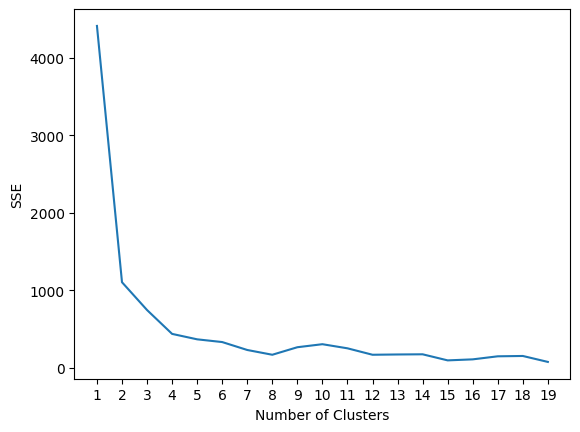

In [92]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

> Elbow é um método utilizado para descobrir o número certo de clusters. Somente observando o gráfico acima não é tão simples definir esse número, por isso utilizamos a biblioteca kneed

In [94]:
kl = KneeLocator(range(1, 20), sse, curve="convex", direction="decreasing")
kl.elbow

4

> 4 é o número de cluster que vamos utilizar

### Usando 4 Clusters

In [99]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(features)

KMeans(init='random', n_clusters=4)

In [100]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = month_level.index.values
cluster_map['cluster'] = kmeans.labels_

In [101]:
cluster_map.head()

,data_index,cluster
0,NYC_1_ACCESORIES_1,2
1,NYC_1_ACCESORIES_2,3
2,NYC_1_HOME_&_GARDEN_1,2
3,NYC_1_HOME_&_GARDEN_2,3
4,NYC_1_SUPERMARKET_1,3


In [102]:
unique_clusters = cluster_map['cluster'].unique()
clusters = {}
for cluster in unique_clusters:
    similar_indices = cluster_map[cluster_map['cluster'] == cluster]['data_index']
    clusters[cluster] = similar_indices
clusters.keys()

dict_keys([2, 3, 0, 1])

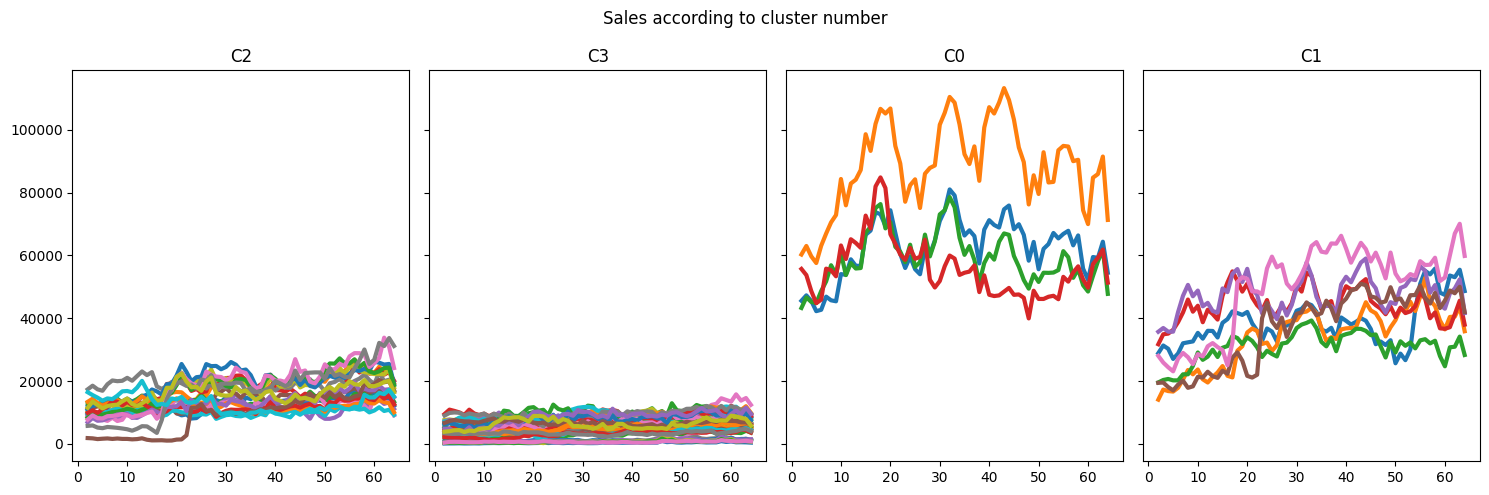

In [103]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
axes = axes.flatten()
ax_idx = 0
for key in clusters.keys():
    plt.axes(axes[ax_idx])
    cluster = clusters[key].values
    for i in range(0, len(cluster)):
        plt.plot(month_level.loc[cluster[i]],
                lw = 3,
            )
    ax_idx += 1
    plt.title("C" + str(key))
plt.suptitle('Sales according to cluster number')
plt.tight_layout()
plt.show()

> Os cluster são diferentes baseado no número total de itens vendidos, cada cluster possui vendas variadas e diferentes vendas (mais baixas e mais altas).

> Exemplo: C0 tem store_department onde a vendas estão no intervalo de 40.000 a 100.000, em contraste C3 tem store_department que têm vendas no intervalo de 0 a 20.000

In [106]:
clusters[2] # podemos ver as loja_departamento que faz parte do cluster que nesse caso é o cluster C2

0        NYC_1_ACCESORIES_1
2     NYC_1_HOME_&_GARDEN_1
5       NYC_1_SUPERMARKET_2
9     NYC_2_HOME_&_GARDEN_1
11      NYC_2_SUPERMARKET_1
14       NYC_3_ACCESORIES_1
18      NYC_3_SUPERMARKET_1
19      NYC_3_SUPERMARKET_2
30    BOS_1_HOME_&_GARDEN_1
33      BOS_1_SUPERMARKET_2
37    BOS_2_HOME_&_GARDEN_1
40      BOS_2_SUPERMARKET_2
44    BOS_3_HOME_&_GARDEN_1
47      BOS_3_SUPERMARKET_2
51    PHI_1_HOME_&_GARDEN_1
54      PHI_1_SUPERMARKET_2
58    PHI_2_HOME_&_GARDEN_1
61      PHI_2_SUPERMARKET_2
65    PHI_3_HOME_&_GARDEN_1
68      PHI_3_SUPERMARKET_2
Name: data_index, dtype: object